<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelling" data-toc-modified-id="Modelling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Utilities" data-toc-modified-id="Utilities-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Utilities</a></span></li></ul></li><li><span><a href="#Product-with-most-fluid-price" data-toc-modified-id="Product-with-most-fluid-price-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Product with most fluid price</a></span><ul class="toc-item"><li><span><a href="#Training-Model" data-toc-modified-id="Training-Model-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Training Model</a></span></li><li><span><a href="#Price-Optimization-Demonstration" data-toc-modified-id="Price-Optimization-Demonstration-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Price Optimization Demonstration</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm

import datetime

pd.set_option('display.max_row', 500)

In [2]:
data = pd.read_csv('../data/prepared/interpolated_demand_history.csv')
data

,Unnamed: 0,product_id,order_purchase_timestamp,sales,price
0,0,005030ef108f58b46b78116f754d8d38,2017-10-16,1.0,13.99
1,10,005030ef108f58b46b78116f754d8d38,2017-10-23,0.0,13.99
2,11,005030ef108f58b46b78116f754d8d38,2017-10-30,0.0,13.99
3,12,005030ef108f58b46b78116f754d8d38,2017-11-06,0.0,13.99
4,1,005030ef108f58b46b78116f754d8d38,2017-11-13,3.0,13.99
...,...,...,...,...,...
50273,26,ffc9caf33e2d1e9f44e3e06da19085f7,2018-07-02,0.0,224.00
50274,27,ffc9caf33e2d1e9f44e3e06da19085f7,2018-07-09,0.0,224.00
50275,28,ffc9caf33e2d1e9f44e3e06da19085f7,2018-07-16,0.0,224.00
50276,29,ffc9caf33e2d1e9f44e3e06da19085f7,2018-07-23,0.0,224.00


In [3]:
data.groupby('product_id').price.nunique().sort_values()

product_id
005030ef108f58b46b78116f754d8d38     2
5b3aa845bba5aa7ba1216e36ae882cfa     2
5b226d7c52f86ac72457617f78cff95d     2
59fe488ea6ac9439bc86663f4a564c23     2
59f09deeea7c839a9212a19f3416b892     2
                                    ..
d285360f29ac7fd97640bf0baef03de0    21
656e0eca68dcecf6a31b8ececfabe3e8    21
53b36df67ebb7c41585e8d54d6772e08    25
461f43be3bdf8844e65b62d9ac2c7a5a    25
e0d64dcfaa3b6db5c54ca298ae101d05    29
Name: price, Length: 1076, dtype: int64

# Modelling

### Utilities

In [4]:
# !pip3 install wandb

import wandb
from wandb.keras import WandbCallback
import tensorflow as tf

2022-05-26 20:02:45.468838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 20:02:45.468953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def show_sample(ds, n_sample=3):
    for x in ds.take(n_sample):
        print(x)

In [6]:
def show_history(history):
    fig = plt.figure(figsize=(14, 8))
    plt.plot(pd.DataFrame(history.history)[['loss', 'val_loss']])

## Product with most fluid price

In [8]:
data.groupby('product_id').sales.sum().sort_values(ascending=False)

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527.0
99a4788cb24856965c36a24e339b6058    488.0
422879e10f46682990de24d770e7f83d    484.0
389d119b48cf3043d311335e499d9c6b    392.0
368c6c730842d78016ad823897a372db    388.0
                                    ...  
242e1933d9cb1c789d3c6a3f2d083ba0      9.0
0d90fced28b749fa0468818d98cb8212      9.0
ad7c531c2001111873dcfed9d8317439      9.0
e2fcaac49de7a3a90f0dc74d7b1e9f10      9.0
88bd8458fdc2ceec3e71ef1d867a7b45      9.0
Name: sales, Length: 1076, dtype: float64

In [108]:
wandb.init(project="fluid-price-product", entity="anakbangkit", reinit=True)
config = wandb.config

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,58
best_val_loss,3.11415
epoch,108
loss,13.6409
val_loss,3.22153


2022-05-26 20:30:28.986529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 20:30:28.986570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Training Model

In [109]:
config.product_id = 'e0d64dcfaa3b6db5c54ca298ae101d05'
config.test_size = 0.3
config.window_size = 4
config.batch_size = 64
config.buffer_size = 64

In [110]:
poi_product = data[data.product_id==config.product_id]
poi_product

,Unnamed: 0,product_id,order_purchase_timestamp,sales,price
43367,0,e0d64dcfaa3b6db5c54ca298ae101d05,2017-03-06,4.0,237.355000
43368,50,e0d64dcfaa3b6db5c54ca298ae101d05,2017-03-13,0.0,237.355000
43369,51,e0d64dcfaa3b6db5c54ca298ae101d05,2017-03-20,0.0,237.355000
43370,1,e0d64dcfaa3b6db5c54ca298ae101d05,2017-03-27,2.0,255.610000
43371,2,e0d64dcfaa3b6db5c54ca298ae101d05,2017-04-03,2.0,255.610000
43372,52,e0d64dcfaa3b6db5c54ca298ae101d05,2017-04-10,0.0,255.610000
43373,53,e0d64dcfaa3b6db5c54ca298ae101d05,2017-04-17,0.0,255.610000
43374,54,e0d64dcfaa3b6db5c54ca298ae101d05,2017-04-24,0.0,255.610000
43375,55,e0d64dcfaa3b6db5c54ca298ae101d05,2017-05-01,0.0,255.610000
43376,56,e0d64dcfaa3b6db5c54ca298ae101d05,2017-05-08,0.0,255.610000


In [111]:
config.split_time = int((1 - config.test_size) * len(poi_product))

In [113]:
def train_val_split(data, time_step=config.split_time):
    
    train = data.iloc[:time_step]
    valid = data.iloc[time_step:]

    return train, valid

# Split the dataset
train, valid = train_val_split(poi_product)

In [114]:
def create_windowed_dataset(data, window_size=config.window_size, batch_size=config.batch_size, buffer_size=config.buffer_size):
    data = data[['sales', 'price']].values
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(buffer_size)
    ds = ds.map(lambda w: ((w[:-1], w[-1:, 1]), w[-1:, 0]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = create_windowed_dataset(train)
valid_set = create_windowed_dataset(valid)

In [117]:
show_sample(train_set)

((<tf.Tensor: shape=(49, 4, 2), dtype=float64, numpy=
array([[[  2.   , 255.61 ],
        [  0.   , 255.61 ],
        [  0.   , 255.61 ],
        [  0.   , 255.61 ]],

       [[  0.   , 255.61 ],
        [  0.   , 255.61 ],
        [  0.   , 255.61 ],
        [  0.   , 255.61 ]],

       [[  0.   , 170.   ],
        [  1.   , 249.8  ],
        [  0.   , 249.8  ],
        [  0.   , 249.8  ]],

       [[  0.   , 235.99 ],
        [  4.   , 187.995],
        [  3.   , 189.99 ],
        [  1.   , 179.9  ]],

       [[  1.   , 209.99 ],
        [  2.   , 239.99 ],
        [  1.   , 239.99 ],
        [  0.   , 239.99 ]],

       [[  0.   , 249.8  ],
        [  1.   , 199.   ],
        [  2.   , 199.   ],
        [  2.   , 199.   ]],

       [[  2.   , 199.   ],
        [  0.   , 199.   ],
        [  3.   , 165.   ],
        [  5.   , 150.302]],

       [[ 11.   , 179.9  ],
        [  0.   , 179.9  ],
        [  1.   , 158.   ],
        [ 13.   , 158.   ]],

       [[  0.   , 255.61 ],
      

In [118]:
# config.rnn_unit = 32
config.fc1_unit = 64
config.fc2_unit = 32

In [120]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, GRU, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# def build_model(rnn_unit, fc1_unit, fc2_unit):
#     history_input = Input(shape=(config.window_size, 2))
#     price_input = Input(shape=(1))
    
#     gru = GRU(rnn_unit, return_sequences=True)(history_input)
#     lstm = LSTM(rnn_unit, return_sequences=True)(history_input)
#     rnn_concat = Concatenate(axis=2)([gru, lstm])
#     rnn_ensemble = LSTM(rnn_unit)(rnn_concat)
    
#     concat_ = Concatenate()([rnn_ensemble, price_input])
#     fc = Dense(fc1_unit, activation='relu', use_bias=False)(concat_)
#     fc = Dense(fc2_unit, activation='relu', use_bias=False)(fc)
#     output = Dense(1, use_bias=False)(fc)
    
#     model = Model([history_input, price_input], output)
#     return model

def build_model(fc1_unit, fc2_unit):
    history_input = Input(shape=(config.window_size, 2))
    price_input = Input(shape=(1))
    
    history_flat = Flatten()(history_input)
    fc = Dense(fc1_unit, activation='relu', use_bias=False)(history_flat)
    
    concat_ = Concatenate()([fc, price_input])
    fc = Dense(fc2_unit, activation='relu', use_bias=False)(concat_)
    output = Dense(1, use_bias=False)(fc)
    
    model = Model([history_input, price_input], output)
    return model

In [121]:
model = build_model(
#     rnn_unit=config.rnn_unit,
    fc1_unit=config.fc1_unit,
    fc2_unit=config.fc2_unit,
)

In [122]:
model.compile(
    optimizer=Adam(),
    loss='mse',
)

In [123]:
earlystopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [124]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=200,
    callbacks=[WandbCallback(), earlystopping_cb],
)

Epoch 1/200
1/1 [==============================] - 1s 722ms/step - loss: 401.8868 - val_loss: 69.2076 - _timestamp: 1653572031.0000 - _runtime: 212.0000
Epoch 2/200
1/1 [==============================] - 0s 121ms/step - loss: 127.2613 - val_loss: 30.9884 - _timestamp: 1653572031.0000 - _runtime: 212.0000
Epoch 3/200
1/1 [==============================] - 0s 95ms/step - loss: 103.0757 - val_loss: 46.1213 - _timestamp: 1653572031.0000 - _runtime: 212.0000
Epoch 4/200
1/1 [==============================] - 0s 97ms/step - loss: 152.9075 - val_loss: 54.3950 - _timestamp: 1653572031.0000 - _runtime: 212.0000
Epoch 5/200
1/1 [==============================] - 0s 102ms/step - loss: 171.2301 - val_loss: 49.4026 - _timestamp: 1653572031.0000 - _runtime: 212.0000
Epoch 6/200
1/1 [==============================] - 0s 96ms/step - loss: 151.2197 - val_loss: 38.3242 - _timestamp: 1653572031.0000 - _runtime: 212.0000
Epoch 7/200
1/1 [==============================] - 0s 115ms/step - loss: 113.5926 - v

Epoch 55/200
1/1 [==============================] - 0s 117ms/step - loss: 11.8944 - val_loss: 20.3489 - _timestamp: 1653572038.0000 - _runtime: 219.0000
Epoch 56/200
1/1 [==============================] - 0s 91ms/step - loss: 11.9200 - val_loss: 20.8658 - _timestamp: 1653572038.0000 - _runtime: 219.0000
Epoch 57/200
1/1 [==============================] - 0s 97ms/step - loss: 12.0065 - val_loss: 21.0367 - _timestamp: 1653572038.0000 - _runtime: 219.0000
Epoch 58/200
1/1 [==============================] - 0s 85ms/step - loss: 12.0023 - val_loss: 20.8257 - _timestamp: 1653572038.0000 - _runtime: 219.0000
Epoch 59/200
1/1 [==============================] - 0s 88ms/step - loss: 11.8485 - val_loss: 20.3170 - _timestamp: 1653572039.0000 - _runtime: 220.0000
Epoch 60/200
1/1 [==============================] - 0s 104ms/step - loss: 11.6071 - val_loss: 19.6684 - _timestamp: 1653572039.0000 - _runtime: 220.0000
Epoch 61/200
1/1 [==============================] - 0s 84ms/step - loss: 11.3906 - val

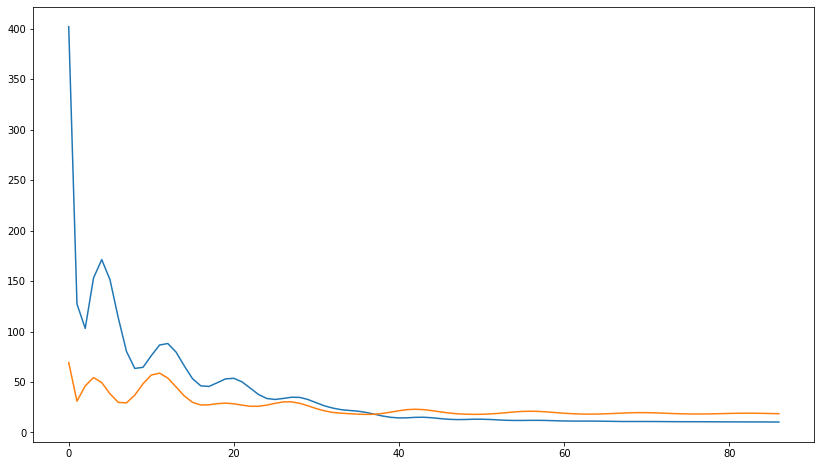

In [125]:
show_history(history)

### Price Optimization Demonstration

In [126]:
def predict_next_week(model, data, price, window_size=config.window_size, batch_size=config.batch_size, buffer_size=config.buffer_size):
    data = data.reshape(-1, window_size, 2)
    price = np.array(price).reshape(-1, 1)
    
    pred = model((data, price)).numpy()
    
    return pred

def forecast(model, data, prices, window_size=config.window_size, batch_size=config.batch_size, buffer_size=config.buffer_size):
    predictions = []
    current_week = data.iloc[-window_size:][['sales', 'price']].values
    for price in prices:
        next_week_sales = predict_next_week(model, current_week, price)[0][0]
        predictions.append(next_week_sales)
        current_week = np.concatenate((current_week, np.array([[next_week_sales, prices[0]]])))[1:]
    
    return predictions


2.9154916


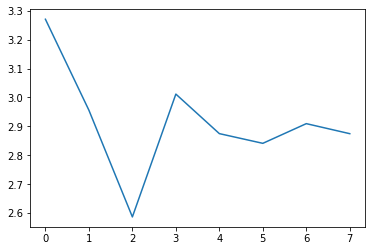

In [127]:
predicted_sales = forecast(model, valid, [146.010000, 146.010000, 146.010000, 146.010000, 146.010000, 146.010000, 146.010000, 146.010000])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

3.1740935


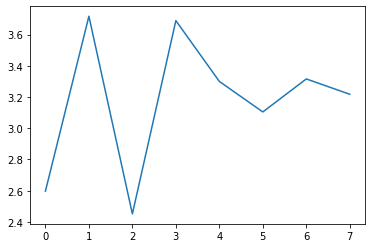

In [143]:
predicted_sales = forecast(model, valid, [130.000000, 146.010000, 146.010000, 146.010000, 146.010000, 146.010000, 146.010000, 146.010000])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

1.7787204


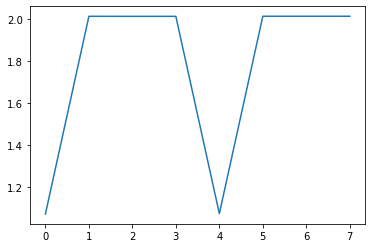

In [98]:
predicted_sales = forecast(model, valid, [100.010000, 160.010000, 160.010000, 160.010000, 100.010000, 160.010000, 160.010000, 160.010000])
plt.plot(predicted_sales)
print(np.mean(predicted_sales))

In [ ]:
valid